In [ ]:
import pandas as pd
import numpy as np
import math

##LSTM
import pandas as pd
import numpy as np
import math

import sklearn
import keras
import keras.backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM, CuDNNLSTM, MaxPooling1D, Conv1D, Flatten, BatchNormalization, Dropout, Input
from keras.models import Model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from multiprocessing import cpu_count 
from joblib import Parallel 
from joblib import delayed 
from datetime import datetime

#import optuna 

from sklearn.preprocessing import StandardScaler

from keras.utils import custom_object_scope
from keras.utils import get_custom_objects
from keras.models import load_model

from keras.layers import LSTM, RepeatVector, TimeDistributed, BatchNormalization, Dropout
from keras.initializers import GlorotUniform
from keras.activations import relu
from joblib import Parallel, delayed

import cProfile

In [ ]:
df_vwc = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_vwc_.npy', allow_pickle=True)
df_stemp = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_stemp_.npy', allow_pickle=True)

df_vwc7 = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd7_vwc.npy', allow_pickle=True)
df_stemp7 = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd7_stemp.npy', allow_pickle=True)

df_vwc11 = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd11_vwc.npy', allow_pickle=True)
df_stemp11 = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd11_stemp.npy', allow_pickle=True)

df_T = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_T.npy', allow_pickle=True)
df_RH = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_RH.npy', allow_pickle=True)
#df_DP = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_DP.npy', allow_pickle=True)
df_Rain = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_Rain.npy', allow_pickle=True)
df_WS = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_WS.npy', allow_pickle=True)
#df_WD = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_WD.npy', allow_pickle=True)
df_S = np.load('/content/drive/Shareddrives/1st Paper/Array_eemd2_S.npy', allow_pickle=True)


In [ ]:
#Scores_IMF = []
dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])
df = dataset[[
       'S2_Top_Temp_Avg', 'S2_Top_VWC_Avg'
       
       ]]
#'Temp', 'Relative Humidity', 'Dew Point', 'Rain', 'Wind Speed', 'Wind Direction', 'Solar Radiation',

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
import tensorflow_probability as tfp


# Define the input and output dimensions
input_dim = df.shape[1]
output_dim = 1

# Define the number of experts
num_experts = 3

# Define the sizes of the hidden layers for each expert
expert_hidden_sizes = [16, 32, 64]

# Define the sizes of the output layers for each expert
expert_output_sizes = [144,144,144]

# Define the sizes of the gating network hidden layers
gating_hidden_sizes = [16, 8]

# Define the size of the output layer of the gating network
gating_output_size = num_experts

# Define the number of training iterations for the EM algorithm
num_iterations = 100

# Define the learning rate for the optimization algorithm
learning_rate = 0.00009

# Load the training data
train_data = np.array(df.head(100))


# Split the training data into input and output sequences
train_input = train_data[:, :]
print('train_input shape', train_input.shape)
train_output = train_data[:, -1:]
print('train_output shape', train_output.shape)

# Define the experts
experts = []
for i in range(num_experts):
    expert_input = Input(shape=(input_dim,))
    expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_input)
    expert_hidden = Dropout(0.2)(expert_hidden)
    expert_output = Dense(expert_output_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_hidden)
    expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_output)  # Add this line
    experts.append(Model(inputs=expert_input, outputs=expert_output))

# Define the gating network
gating_input = Input(shape=(input_dim,))
gating_hidden = gating_input
for i in range(len(gating_hidden_sizes)):
    gating_hidden = Dense(gating_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(gating_hidden)

gating_output = Dense(num_experts + num_experts * 2, activation=None, kernel_initializer='he_normal')(gating_hidden)
logits = gating_output[:, :num_experts]
params = gating_output[:, num_experts:]
params = tf.reshape(params, [-1, num_experts, 2])

gating_distribution = tfp.distributions.MixtureSameFamily(
    mixture_distribution=tfp.distributions.Categorical(logits=logits),
    components_distribution=tfp.distributions.Normal(
        loc=params[..., 0],
        scale=tf.math.softplus(params[..., 1])
    )
)

gating_model = Model(inputs=gating_input, outputs=logits)

# Define the MoE model
inputs = Input(shape=(input_dim,))
outputs = []
for i in range(num_experts):
    expert_output = experts[i](inputs)
    outputs.append(expert_output)

gating_output = gating_model(inputs)
weighted_outputs = [tf.expand_dims(gating_output[:, i], axis=-1) * expert_output for i, expert_output in enumerate(outputs)]

outputs = tf.reduce_sum(weighted_outputs, axis=0)

moe_model = Model(inputs=inputs, outputs=outputs)

# Define the loss function
def moe_loss(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    expert_losses = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    expert_losses = tf.expand_dims(expert_losses, axis=-1)
    
    # Apply softmax to the logits to get probabilities
    gating_probabilities = tf.nn.softmax(gating_output, axis=-1)
    
    # Multiply expert_losses with the gating probabilities instead of logits
    gating_losses = tf.reduce_sum(tf.multiply(expert_losses, gating_probabilities), axis=-1)
    return tf.reduce_mean(gating_losses)

# Define the optimization algorithm
optimizer = Adam(lr=learning_rate)

# Train the MoE model with the EM algorithm
for iteration in range(num_iterations):

    # E step: Compute the responsibilities of each expert for each data point
    gating_output = tf.constant(gating_model.predict(train_input), dtype=tf.float64)
    gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value


    # M step: Update the parameters of each expert and the gating network
    for i in range(num_experts):
        expert_input = train_input
        expert_output = experts[i](expert_input)
        expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)
        
        with tf.GradientTape() as tape:
            # Watch the trainable variables of the expert model
            tape.watch(experts[i].trainable_variables)

            # Define the expert model and calculate the expert_loss
            expert_output = experts[i](expert_input)
            expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        # Compute the gradients
        expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
        # Clip gradients for expert models
        expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

        # Update the variables
        optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))


    gating_input = train_input
    
    with tf.GradientTape() as tape:
      # Watch the trainable variables of the gating model
      tape.watch(gating_model.trainable_variables)

      # Define the gating model and calculate the gating_loss
      gating_output = gating_model(gating_input)
      gating_loss = moe_loss(tf.constant(train_output, dtype=tf.float32), moe_model(gating_input))

    # Compute the gradients
    gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
    # Clip gradients for the gating model
    gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]
    
    # Update the variables
    optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))


    # Evaluate the performance of the MoE model on the training set
    train_loss = moe_loss(train_output, moe_model.predict(train_input))
    print('Iteration %d: Training loss = %.6f' % (iteration + 1, train_loss))

# Make predictions on the test set using the MoE model
test_data = np.array(df[-100:])
test_input = test_data[:, :]
test_output = test_data[:, -1:]
test_predictions = moe_model.predict(test_input)

test_loss = moe_loss(test_output, test_predictions)
print('Test loss = %.6f' % test_loss)


**Vanilla version: 3 simple NN adding he Initializer and earlty stopping**

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
import tensorflow_probability as tfp
from keras.callbacks import EarlyStopping


# Define the input and output dimensions
input_dim = df.shape[1]
output_dim = 1

# Define the number of experts
num_experts = 3

# Define the sizes of the hidden layers for each expert
expert_hidden_sizes = [16, 32, 64]

# Define the sizes of the output layers for each expert
expert_output_sizes = [144,144,144]

# Define the sizes of the gating network hidden layers
gating_hidden_sizes = [16, 8]

# Define the size of the output layer of the gating network
gating_output_size = num_experts

# Define the number of training iterations for the EM algorithm
num_iterations = 100

# Define the learning rate for the optimization algorithm
learning_rate = 0.0001

# Load the training data
train_data = np.array(df.head(144))


# Split the training data into input and output sequences
train_input = train_data[:, :]
print('train_input shape', train_input.shape)
train_output = train_data[:, -1:]
print('train_output shape', train_output.shape)

# Define the experts
experts = []
for i in range(num_experts):
    expert_input = Input(shape=(input_dim,))
    expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_input)
    expert_hidden = Dropout(0.2)(expert_hidden)
    expert_output = Dense(expert_output_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_hidden)
    expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_output)  # Add this line
    experts.append(Model(inputs=expert_input, outputs=expert_output))

# Define the gating network
gating_input = Input(shape=(input_dim,))
gating_hidden = gating_input
for i in range(len(gating_hidden_sizes)):
    gating_hidden = Dense(gating_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(gating_hidden)

gating_output = Dense(num_experts + num_experts * 2, activation=None, kernel_initializer='he_normal')(gating_hidden)
logits = gating_output[:, :num_experts]
params = gating_output[:, num_experts:]
params = tf.reshape(params, [-1, num_experts, 2])

gating_distribution = tfp.distributions.MixtureSameFamily(
    mixture_distribution=tfp.distributions.Categorical(logits=logits),
    components_distribution=tfp.distributions.Normal(
        loc=params[..., 0],
        scale=tf.math.softplus(params[..., 1])
    )
)

gating_model = Model(inputs=gating_input, outputs=logits)

# Define the MoE model
inputs = Input(shape=(input_dim,))
outputs = []
for i in range(num_experts):
    expert_output = experts[i](inputs)
    outputs.append(expert_output)

gating_output = gating_model(inputs)
weighted_outputs = [tf.expand_dims(gating_output[:, i], axis=-1) * expert_output for i, expert_output in enumerate(outputs)]

outputs = tf.reduce_sum(weighted_outputs, axis=0)

moe_model = Model(inputs=inputs, outputs=outputs)

# Define the loss function
def moe_loss(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    expert_losses = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    expert_losses = tf.expand_dims(expert_losses, axis=-1)
    
    # Apply softmax to the logits to get probabilities
    gating_probabilities = tf.nn.softmax(gating_output, axis=-1)
    
    # Multiply expert_losses with the gating probabilities instead of logits
    gating_losses = tf.reduce_sum(tf.multiply(expert_losses, gating_probabilities), axis=-1)
    return tf.reduce_mean(gating_losses)

# Define the optimization algorithm
optimizer = Adam(lr=learning_rate)


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, min_delta=0, baseline=None)
early_stopping.set_model(moe_model)  # Add this line
early_stopping.best = float('inf')  # Add this line

# Train the MoE model with the EM algorithm
iteration = 0
while iteration < num_iterations:

    # E step: Compute the responsibilities of each expert for each data point
    gating_output = tf.constant(gating_model.predict(train_input), dtype=tf.float64)
    gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value


    # M step: Update the parameters of each expert and the gating network
    for i in range(num_experts):
        expert_input = train_input
        expert_output = experts[i](expert_input)
        expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)
        
        with tf.GradientTape() as tape:
            # Watch the trainable variables of the expert model
            tape.watch(experts[i].trainable_variables)

            # Define the expert model and calculate the expert_loss
            expert_output = experts[i](expert_input)
            expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        # Compute the gradients
        expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
        # Clip gradients for expert models
        expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

        # Update the variables
        optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))

    gating_input = train_input
    
    with tf.GradientTape() as tape:
      # Watch the trainable variables of the gating model
      tape.watch(gating_model.trainable_variables)

      # Define the gating model and calculate the gating_loss
      gating_output = gating_model(gating_input)
      gating_loss = moe_loss(tf.constant(train_output, dtype=tf.float32), moe_model(gating_input))

    # Compute the gradients
    gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
    # Clip gradients for the gating model
    gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]
    
    # Update the variables
    optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))


    # Evaluate the performance of the MoE model on the training set
    train_loss = moe_loss(train_output, moe_model.predict(train_input))
    print('Iteration %d: Training loss = %.6f' % (iteration + 1, train_loss))
    early_stopping.on_epoch_end(iteration, logs={'val_loss': train_loss})


    if early_stopping.stopped_epoch > 0:
      print('Early stopping triggered after iteration %d' % early_stopping.stopped_epoch)
      break
    
    iteration += 1


# Make predictions on the test set using the MoE model
test_data = np.array(df[-144:])
test_input = test_data[:, :]
test_output = test_data[:, -1:]
test_predictions = moe_model.predict(test_input)

test_loss = moe_loss(test_output, test_predictions)
print('Test loss = %.6f' % test_loss)


train_input shape (144, 2)
train_output shape (144, 1)
5/5 [==============================] - 0s 5ms/step
Iteration 1: Training loss = 9622792.000000
5/5 [==============================] - 0s 4ms/step
Iteration 2: Training loss = 9477563.000000
5/5 [==============================] - 0s 3ms/step
Iteration 3: Training loss = 9321474.000000
5/5 [==============================] - 0s 5ms/step
Iteration 4: Training loss = 9151894.000000
5/5 [==============================] - 0s 4ms/step
Iteration 5: Training loss = 8968573.000000
5/5 [==============================] - 0s 3ms/step
Iteration 6: Training loss = 8772125.000000
5/5 [==============================] - 0s 2ms/step
Iteration 7: Training loss = 8563696.000000
5/5 [==============================] - 0s 3ms/step
Iteration 8: Training loss = 8344747.500000
5/5 [==============================] - 0s 3ms/step
Iteration 9: Training loss = 8116824.000000
5/5 [==============================] - 0s 3ms/step
Iteration 10: Training loss = 7881578.5

**Adding Normalization of data, scheduler, clip gradients for gating network, and using input formating functions**

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_probability as tfp

def split_dataset(data):
  # split into standard weeks
  train, test = data[0:-6047], data[-6048:]
  #train, test = data[:-5817], data[-5817:-57]
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test

def to_supervised(train, n_input):
    # Flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # Step over the entire history one time step at a time
    for _ in range(len(data)):
        # Define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + 1
        # Ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end, 0])  # Modify this line to only include the first future time step
        # Move along one time step
        in_start += 1
    return np.array(X), np.array(y)


train, test = split_dataset(df.values)


# Define the input and output dimensions
input_dim = df.shape[1]
output_dim = 1

# Define the number of experts
num_experts = 3

# Define the sizes of the hidden layers for each expert
expert_hidden_sizes = [16, 32, 64]

# Define the sizes of the output layers for each expert
expert_output_sizes = [144,144,144]

# Define the sizes of the gating network hidden layers
gating_hidden_sizes = [16, 8]

# Define the size of the output layer of the gating network
gating_output_size = num_experts

# Define the number of training iterations for the EM algorithm
num_iterations = 100

# Define the learning rate for the optimization algorithm
learning_rate = 0.0001

#Train test split
train, test = split_dataset(df.values)

# Input output
out, _ = to_supervised(train, 144)

# Load the training data
#train_data = np.array(df.head(17199))

# Reshape train_data so that the last column represents the output sequence
train_input = train.reshape(train.shape[0]*train.shape[1], train.shape[2])[:-145,:]
train_output = out[:,:,1]


def build_moe_model(input_dim, output_dim, expert_hidden_sizes, expert_output_sizes,
                    gating_hidden_sizes, num_experts=3, learning_rate=0.0001,
                    num_iterations=100):

    # Define the experts
    experts = []
    for i in range(num_experts):
        expert_input = Input(shape=(input_dim,))
        expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal', input_shape=(input_dim,))(expert_input)
        expert_hidden = Dropout(0.2)(expert_hidden)
        expert_output = Dense(expert_output_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_hidden)
        expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_output)
        experts.append(Model(inputs=expert_input, outputs=expert_output))


    # Define the gating network
    gating_input = Input(shape=(input_dim,))
    gating_hidden = gating_input
    for i in range(len(gating_hidden_sizes)):
        gating_hidden = Dense(gating_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(gating_hidden)

    gating_output = Dense(num_experts + num_experts * 2, activation=None, kernel_initializer='he_normal')(gating_hidden)
    logits = gating_output[:, :num_experts]
    params = gating_output[:, num_experts:]
    params = tf.reshape(params, [-1, num_experts, 2])

    gating_distribution = tfp.distributions.MixtureSameFamily(
        mixture_distribution=tfp.distributions.Categorical(logits=logits),
        components_distribution=tfp.distributions.Normal(
            loc=params[..., 0],
            scale=tf.math.softplus(params[..., 1])
        )
    )

    gating_model = Model(inputs=gating_input, outputs=logits)

    # Define the MoE model
    inputs = Input(shape=(input_dim,))
    outputs = []
    for i in range(num_experts):
        expert_output = experts[i](inputs)
        outputs.append(expert_output)

    gating_output = gating_model(inputs)
    weighted_outputs = [tf.expand_dims(gating_output[:, i], axis=-1) * expert_output for i, expert_output in enumerate(outputs)]

    outputs = tf.reduce_sum(weighted_outputs, axis=0)

    moe_model = Model(inputs=inputs, outputs=outputs)

    return moe_model, experts, gating_model


# Normalize input data
train_input = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)

# Pad output sequences to the same length

# train_output = pad_sequences(train_output, maxlen=max(expert_output_sizes), padding='post', dtype='float32')


moe_model, experts, gating_model = build_moe_model(input_dim, output_dim, expert_hidden_sizes,
                                                   expert_output_sizes, gating_hidden_sizes)

# Define the loss function
def moe_loss(y_true, y_pred, gating_output):
    y_true = tf.cast(y_true, y_pred.dtype)
    expert_losses = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    expert_losses = tf.expand_dims(expert_losses, axis=-1)
    
    # Apply softmax to the logits to get probabilities
    gating_probabilities = tf.nn.softmax(gating_output, axis=-1)
    
    # Multiply expert_losses with the gating probabilities instead of logits
    gating_losses = tf.reduce_sum(tf.multiply(expert_losses, gating_probabilities), axis=-1)
    return tf.reduce_mean(gating_losses)



# Define the optimization algorithm
optimizer = Adam(learning_rate=learning_rate)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


lr_scheduler = LearningRateScheduler(scheduler)

# Train the MoE model with the EM algorithm
# Train the MoE model with the EM algorithm
iteration = 0
while iteration < num_iterations:

    # E step: Compute the responsibilities of each expert for each data point
    gating_output = tf.constant(gating_model.predict(train_input), dtype=tf.float64)
    gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value to avoid zero division

    # M step: Update the parameters of each expert and the gating network
    for i in range(num_experts):
        expert_input = train_input
        expert_output = experts[i](expert_input)
        expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        with tf.GradientTape() as tape:
            # Watch the trainable variables of the expert model
            tape.watch(experts[i].trainable_variables)

            # Define the expert model and calculate the expert_loss
            expert_output = experts[i](expert_input)
            expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        # Compute the gradients
        expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
        # Clip gradients for expert models
        expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

        # Update the variables
        optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))
    
    current_learning_rate = scheduler(iteration, optimizer.learning_rate.numpy())
    optimizer.learning_rate.assign(current_learning_rate)

    gating_input = train_input

    with tf.GradientTape() as tape:
        # Watch the trainable variables of the gating model
        tape.watch(gating_model.trainable_variables)

        # Define the gating model and calculate the gating_loss
        gating_output = gating_model(gating_input)
        gating_loss = moe_loss(tf.constant(train_output, dtype=tf.float32), moe_model(train_input), gating_output)


    # Compute the gradients
    gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
    # Clip gradients for the gating model
    gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]

    # Update the variables
    optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))

    # Evaluate the performance of the MoE model on the training set
    train_loss = moe_loss(train_output, moe_model.predict(train_input), gating_model.predict(train_input))


    print('Iteration %d: Training loss = %.6f' % (iteration + 1, train_loss))

    # Stop training if the learning rate becomes too small
    if current_learning_rate < 1e-6:
        print('Learning rate dropped below 1e-6 after iteration %d' % iteration)
        break

    iteration += 1

# Make predictions on the test set using the MoE model
# test_data = np.array(df[-144:])
# test_input = test_data[:, :]
# test_output = test_data[:, -1]
# test_output = [[int(x)] for x in test_output]

# Input output
out_test, _ = to_supervised(test, 144)

# Load the training data
#train_data = np.array(df.head(17199))

# Reshape train_data so that the last column represents the output sequence
test_input = test.reshape(test.shape[0]*test.shape[1], test.shape[2])[:-145,:]
test_output = out_test[:,:,1]

# Normalize test input data
test_input = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

# # Pad test output sequences to the same length
# test_output_padded = []
# for seq in test_output:
#     padded_seq = seq[:1] + [seq[0]] * (max_output_len - 1)
#     test_output_padded.append(padded_seq)
# test_output = np.array(test_output_padded)

# Make predictions on the test set using the MoE model
test_predictions = moe_model.predict(test_input)

test_loss = moe_loss(test_output, test_predictions, gating_model.predict(test_input))

print('Test loss = %.6f' % test_loss)


563/563 [==============================] - 1s 1ms/step
Iteration 1: Training loss = 107.021301
563/563 [==============================] - 1s 1ms/step
Iteration 2: Training loss = 108.928482
563/563 [==============================] - 1s 1ms/step
Iteration 3: Training loss = 111.087547
563/563 [==============================] - 1s 1ms/step
Iteration 4: Training loss = 113.538475
563/563 [==============================] - 1s 1ms/step
Iteration 5: Training loss = 116.306496
563/563 [==============================] - 1s 1ms/step
Iteration 6: Training loss = 119.409637
563/563 [==============================] - 1s 2ms/step
Iteration 7: Training loss = 122.862175
563/563 [==============================] - 1s 1ms/step
Iteration 8: Training loss = 126.675789
563/563 [==============================] - 1s 1ms/step
Iteration 9: Training loss = 130.858124
563/563 [==============================] - 1s 2ms/step
Iteration 10: Training loss = 135.413849
563/563 [==============================] - 1s 1ms

In [ ]:
test_predictions_denormalized = test_predictions * np.std(train_output, axis=0) + np.mean(train_output, axis=0)

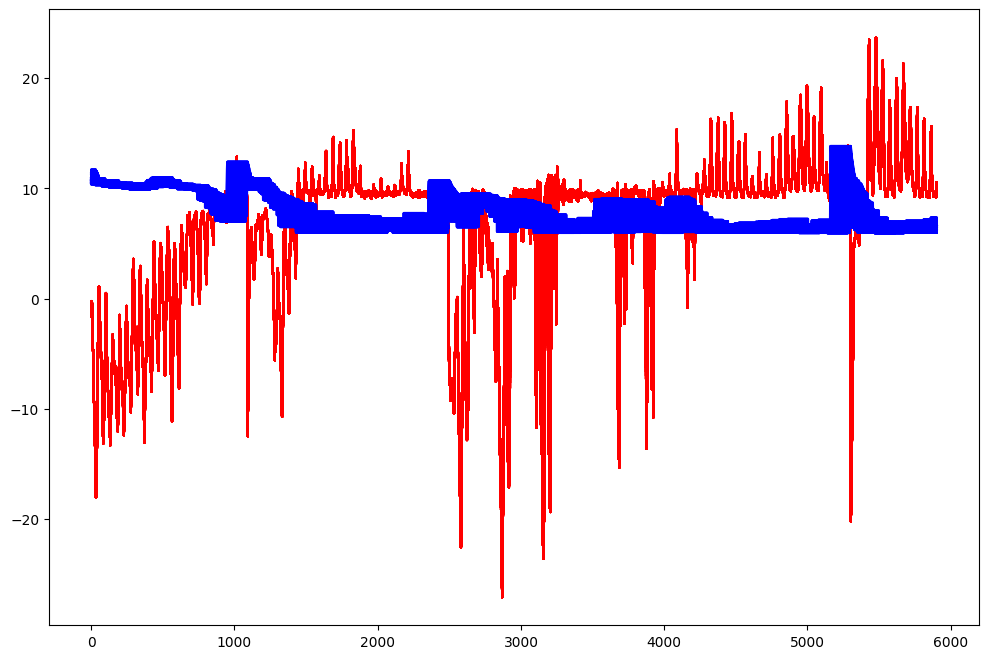

In [ ]:
import matplotlib.pyplot as plt

# Create a new figure object with a larger size
fig = plt.figure(figsize=(12, 8))

# Create your plot within the new figure object
plt.plot(test_predictions_denormalized , color = 'red')
plt.plot(test_output, color = 'blue')

# Display the plot
plt.show()


**Including Autoencoder as one of the experts.**

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_probability as tfp

def split_dataset(data):
  # split into standard weeks
  train, test = data[0:-6047], data[-6048:]
  #train, test = data[:-5817], data[-5817:-57] 6048
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test

def to_supervised(train, n_input):
    # Flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # Step over the entire history one time step at a time
    for _ in range(len(data)):
        # Define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + 1
        # Ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end, 0])  # Modify this line to only include the first future time step
        # Move along one time step
        in_start += 1
    return np.array(X), np.array(y)


train, test = split_dataset(df.values)


# Define the input and output dimensions
input_dim = df.shape[1]
output_dim = 1

# Define the number of experts
num_experts = 3

# Define the sizes of the hidden layers for each expert
expert_hidden_sizes = [16, 32, 64]

# Define the sizes of the output layers for each expert
expert_output_sizes = [144,144,144]

# Define the sizes of the gating network hidden layers
gating_hidden_sizes = [16, 8]

# Define the size of the output layer of the gating network
gating_output_size = num_experts

# Define the number of training iterations for the EM algorithm
num_iterations = 100

# Define the learning rate for the optimization algorithm
learning_rate = 0.0001

#Train test split
train, test = split_dataset(df.values)

# Input output
out, _ = to_supervised(train, 144)

# Load the training data
#train_data = np.array(df.head(17199))

# Reshape train_data so that the last column represents the output sequence
train_input = train.reshape(train.shape[0]*train.shape[1], train.shape[2])[:-145,:]
train_output = out[:,:,1]


def build_moe_model_with_autoencoder(input_dim, output_dim, expert_hidden_sizes, expert_output_sizes,
                                     gating_hidden_sizes, num_experts=3, learning_rate=0.0001,
                                     num_iterations=100):
    
    # Define the experts
    experts = []
    for i in range(num_experts):
        if i == 0:  # Replace first expert with an autoencoder
            expert_input = Input(shape=(input_dim,))
            expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_input)
            encoded = Dense(expert_output_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_hidden)
            expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(encoded)
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=encoded))  # Return encoded representation
        else:
            expert_input = Input(shape=(input_dim,))
            expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_input)
            expert_hidden = Dropout(0.2)(expert_hidden)
            expert_output = Dense(expert_output_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_hidden)
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_output)
            experts.append(Model(inputs=expert_input, outputs=expert_output))

    # Define the gating network
    gating_input = Input(shape=(input_dim,))
    gating_hidden = gating_input
    for i in range(len(gating_hidden_sizes)):
        gating_hidden = Dense(gating_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(gating_hidden)

    gating_output = Dense(num_experts + num_experts * 2, activation=None, kernel_initializer='he_normal')(gating_hidden)
    logits = gating_output[:, :num_experts]
    params = gating_output[:, num_experts:]
    params = tf.reshape(params, [-1, num_experts, 2])

    gating_distribution = tfp.distributions.MixtureSameFamily(
        mixture_distribution=tfp.distributions.Categorical(logits=logits),
        components_distribution=tfp.distributions.Normal(
            loc=params[..., 0],
            scale=tf.math.softplus(params[..., 1])
        )
    )

    gating_model = Model(inputs=gating_input, outputs=logits)

    # Define the MoE model
    inputs = Input(shape=(input_dim,))
    outputs = []
    for i in range(num_experts):
        expert_output = experts[i](inputs)
        if i == 0:  # For the autoencoder expert, append encoded representation to outputs list
            outputs.append(expert_output)
        else:
            outputs.append(experts[i](inputs))

    gating_output = gating_model(inputs)
    weighted_outputs = [tf.expand_dims(gating_output[:, i], axis=-1) * expert_output for i, expert_output in enumerate(outputs)]

    outputs = tf.reduce_sum(weighted_outputs, axis=0)

    moe_model = Model(inputs=inputs, outputs=outputs)

    return moe_model, experts, gating_model


# Normalize input data
train_input = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)

# Pad output sequences to the same length

# train_output = pad_sequences(train_output, maxlen=max(expert_output_sizes), padding='post', dtype='float32')


moe_model, experts, gating_model = build_moe_model(input_dim, output_dim, expert_hidden_sizes,
                                                   expert_output_sizes, gating_hidden_sizes)

# Define the loss function
def moe_loss(y_true, y_pred, gating_output):
    y_true = tf.cast(y_true, y_pred.dtype)
    expert_losses = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    expert_losses = tf.expand_dims(expert_losses, axis=-1)
    
    # Apply softmax to the logits to get probabilities
    gating_probabilities = tf.nn.softmax(gating_output, axis=-1)
    
    # Multiply expert_losses with the gating probabilities instead of logits
    gating_losses = tf.reduce_sum(tf.multiply(expert_losses, gating_probabilities), axis=-1)
    return tf.reduce_mean(gating_losses)



# Define the optimization algorithm
optimizer = Adam(learning_rate=learning_rate)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


lr_scheduler = LearningRateScheduler(scheduler)

# Train the MoE model with the EM algorithm
# Train the MoE model with the EM algorithm
iteration = 0
while iteration < num_iterations:

    # E step: Compute the responsibilities of each expert for each data point
    gating_output = tf.constant(gating_model.predict(train_input), dtype=tf.float64)
    gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value

    # M step: Update the parameters of each expert and the gating network
    for i in range(num_experts):
        expert_input = train_input
        expert_output = experts[i](expert_input)
        expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        with tf.GradientTape() as tape:
            # Watch the trainable variables of the expert model
            tape.watch(experts[i].trainable_variables)

            # Define the expert model and calculate the expert_loss
            expert_output = experts[i](expert_input)
            expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        # Compute the gradients
        expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
        # Clip gradients for expert models
        expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

        # Update the variables
        optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))
    
    current_learning_rate = scheduler(iteration, optimizer.learning_rate.numpy())
    optimizer.learning_rate.assign(current_learning_rate)

    gating_input = train_input

    with tf.GradientTape() as tape:
        # Watch the trainable variables of the gating model
        tape.watch(gating_model.trainable_variables)

        # Define the gating model and calculate the gating_loss
        gating_output = gating_model(gating_input)
        gating_loss = moe_loss(tf.constant(train_output, dtype=tf.float32), moe_model(train_input), gating_output)


    # Compute the gradients
    gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
    # Clip gradients for the gating model
    gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]

    # Update the variables
    optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))

    # Evaluate the performance of the MoE model on the training set
    train_loss = moe_loss(train_output, moe_model.predict(train_input), gating_model.predict(train_input))


    print('Iteration %d: Training loss = %.6f' % (iteration + 1, train_loss))

    # Stop training if the learning rate becomes too small
    if current_learning_rate < 1e-6:
        print('Learning rate dropped below 1e-6 after iteration %d' % iteration)
        break

    iteration += 1

# Make predictions on the test set using the MoE model
# test_data = np.array(df[-144:])
# test_input = test_data[:, :]
# test_output = test_data[:, -1]
# test_output = [[int(x)] for x in test_output]

# Input output
out_test, _ = to_supervised(test, 144)

# Load the training data
#train_data = np.array(df.head(17199))

# Reshape train_data so that the last column represents the output sequence
test_input = test.reshape(test.shape[0]*test.shape[1], test.shape[2])[:-145,:]
test_output = out_test[:,:,1]

# Normalize test input data
test_input = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

# # Pad test output sequences to the same length
# test_output_padded = []
# for seq in test_output:
#     padded_seq = seq[:1] + [seq[0]] * (max_output_len - 1)
#     test_output_padded.append(padded_seq)
# test_output = np.array(test_output_padded)

# Make predictions on the test set using the MoE model
test_predictions = moe_model.predict(test_input)

test_loss = moe_loss(test_output, test_predictions, gating_model.predict(test_input))

print('Test loss = %.6f' % test_loss)

563/563 [==============================] - 1s 1ms/step
Iteration 1: Training loss = 136.186615
563/563 [==============================] - 1s 1ms/step
Iteration 2: Training loss = 136.962494
563/563 [==============================] - 1s 1ms/step
Iteration 3: Training loss = 137.838974
563/563 [==============================] - 1s 1ms/step
Iteration 4: Training loss = 138.833313
563/563 [==============================] - 1s 2ms/step
Iteration 5: Training loss = 139.957062
563/563 [==============================] - 1s 2ms/step
Iteration 6: Training loss = 141.225677
563/563 [==============================] - 1s 1ms/step
Iteration 7: Training loss = 142.647842
563/563 [==============================] - 2s 3ms/step
Iteration 8: Training loss = 144.230988
563/563 [==============================] - 1s 1ms/step
Iteration 9: Training loss = 145.981110
563/563 [==============================] - 1s 1ms/step
Iteration 10: Training loss = 147.900925
563/563 [==============================] - 1s 2ms

In [ ]:
test_predictions_denormalized = test_predictions * np.std(train_output, axis=0) + np.mean(train_output, axis=0)

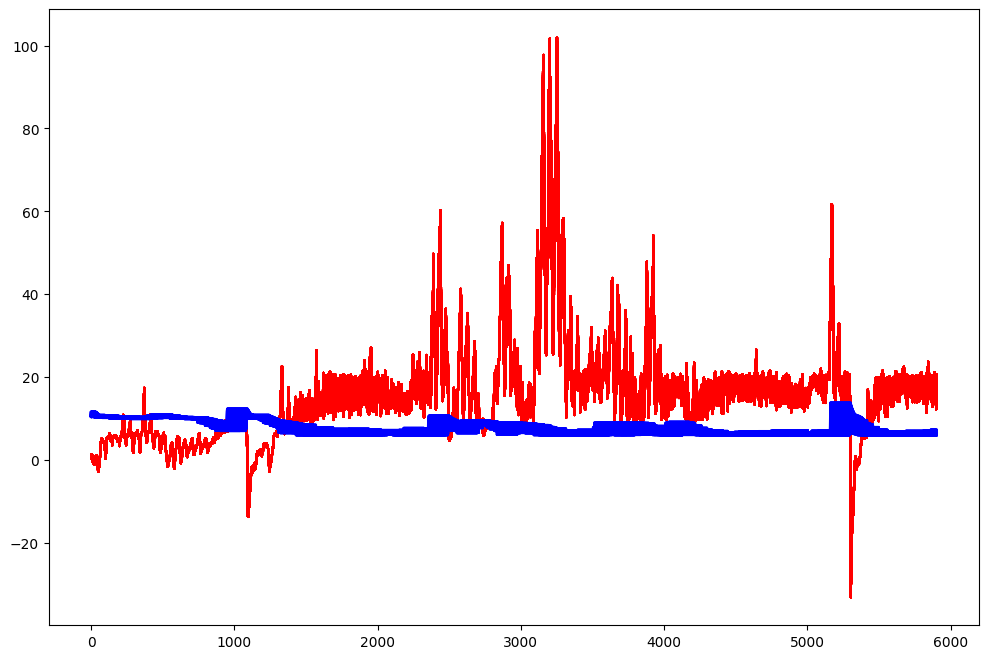

In [ ]:
import matplotlib.pyplot as plt

# Create a new figure object with a larger size
fig = plt.figure(figsize=(12, 8))

# Create your plot within the new figure object
plt.plot(test_predictions_denormalized , color = 'red')
plt.plot(test_output, color = 'blue')

# Display the plot
plt.show()

**Replacing simple NN with CNN and attention-based models**

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Multiply, Add
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_probability as tfp

def split_dataset(data):
  # split into standard weeks
  train, test = data[0:-6047], data[-6048:]
  #train, test = data[:-5817], data[-5817:-57] 6048
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test

def to_supervised(train, n_input):
    # Flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # Step over the entire history one time step at a time
    for _ in range(len(data)):
        # Define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + 1
        # Ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end, 0])  # Modify this line to only include the first future time step
        # Move along one time step
        in_start += 1
    return np.array(X), np.array(y)


train, test = split_dataset(df.values)


# Define the input and output dimensions
input_dim = df.shape[1]
output_dim = 1

# Define the number of experts
num_experts = 3

# Define the sizes of the hidden layers for each expert
expert_hidden_sizes = [16, 32, 64]

# Define the sizes of the output layers for each expert
expert_output_sizes = [144,144,144]

# Define the sizes of the gating network hidden layers
gating_hidden_sizes = [16, 8]

# Define the size of the output layer of the gating network
gating_output_size = num_experts

# Define the number of training iterations for the EM algorithm
num_iterations = 100

# Define the learning rate for the optimization algorithm
learning_rate = 0.0001

#Train test split
train, test = split_dataset(df.values)

# Input output
out, _ = to_supervised(train, 144)

# Load the training data
#train_data = np.array(df.head(17199))

# Reshape train_data so that the last column represents the output sequence
train_input = train.reshape(train.shape[0]*train.shape[1], train.shape[2])[:-145,:]
train_output = out[:,:,1]


def build_moe_model_with_autoencoder(input_dim, output_dim, expert_hidden_sizes, expert_output_sizes,
                                     gating_hidden_sizes, num_experts=3, learning_rate=0.0001,
                                     num_iterations=100):
    
    # Define the experts
    experts = []
    for i in range(num_experts):
        if i == 0:  # Replace first expert with an autoencoder
            expert_input = Input(shape=(input_dim,))
            expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_input)
            encoded = Dense(expert_output_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_hidden)
            expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(encoded)
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=encoded))  # Return encoded representation
        elif i == 1:  # Replace second expert with a CNN expert
            expert_input = Input(shape=(input_dim,))
            expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_input)
            expert_hidden = Dropout(0.2)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for CNN input
            expert_hidden = Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_normal')(expert_hidden)
            expert_hidden = MaxPooling1D(pool_size=2)(expert_hidden)
            expert_hidden = Flatten()(expert_hidden)
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))
        else:  # Replace third expert with an attention-based model
            expert_input = Input(shape=(input_dim,))
            expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_input)
            expert_hidden = Dropout(0.2)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for LSTM input
            expert_hidden, _ = LSTM(expert_hidden_sizes[i], return_state=True, kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))


    # Define the gating network
    gating_input = Input(shape=(input_dim,))
    gating_hidden = gating_input
    for i in range(len(gating_hidden_sizes)):
        gating_hidden = Dense(gating_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(gating_hidden)

    gating_output = Dense(num_experts + num_experts * 2, activation=None, kernel_initializer='he_normal')(gating_hidden)
    logits = gating_output[:, :num_experts]
    params = gating_output[:, num_experts:]
    params = tf.reshape(params, [-1, num_experts, 2])

    gating_distribution = tfp.distributions.MixtureSameFamily(
        mixture_distribution=tfp.distributions.Categorical(logits=logits),
        components_distribution=tfp.distributions.Normal(
            loc=params[..., 0],
            scale=tf.math.softplus(params[..., 1])
        )
    )

    gating_model = Model(inputs=gating_input, outputs=logits)

    # Define the MoE model
    inputs = Input(shape=(input_dim,))
    outputs = []
    for i in range(num_experts):
        expert_output = experts[i](inputs)
        if i == 0:  # For the autoencoder expert, append encoded representation to outputs list
            outputs.append(expert_output)
        else:
            outputs.append(experts[i](inputs))

    gating_output = gating_model(inputs)
    weighted_outputs = [tf.expand_dims(gating_output[:, i], axis=-1) * expert_output for i, expert_output in enumerate(outputs)]

    outputs = tf.reduce_sum(weighted_outputs, axis=0)

    moe_model = Model(inputs=inputs, outputs=outputs)

    return moe_model, experts, gating_model


# Normalize input data
train_input = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)

# Pad output sequences to the same length

# train_output = pad_sequences(train_output, maxlen=max(expert_output_sizes), padding='post', dtype='float32')


moe_model, experts, gating_model = build_moe_model(input_dim, output_dim, expert_hidden_sizes,
                                                   expert_output_sizes, gating_hidden_sizes)

# Define the loss function
def moe_loss(y_true, y_pred, gating_output):
    y_true = tf.cast(y_true, y_pred.dtype)
    expert_losses = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    expert_losses = tf.expand_dims(expert_losses, axis=-1)
    
    # Apply softmax to the logits to get probabilities
    gating_probabilities = tf.nn.softmax(gating_output, axis=-1)
    
    # Multiply expert_losses with the gating probabilities instead of logits
    gating_losses = tf.reduce_sum(tf.multiply(expert_losses, gating_probabilities), axis=-1)
    return tf.reduce_mean(gating_losses)



# Define the optimization algorithm
optimizer = Adam(learning_rate=learning_rate)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


lr_scheduler = LearningRateScheduler(scheduler)

# Train the MoE model with the EM algorithm
# Train the MoE model with the EM algorithm
iteration = 0
while iteration < num_iterations:

    # E step: Compute the responsibilities of each expert for each data point
    gating_output = tf.constant(gating_model.predict(train_input), dtype=tf.float64)
    gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value

    # M step: Update the parameters of each expert and the gating network
    for i in range(num_experts):
        expert_input = train_input
        expert_output = experts[i](expert_input)
        expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        with tf.GradientTape() as tape:
            # Watch the trainable variables of the expert model
            tape.watch(experts[i].trainable_variables)

            # Define the expert model and calculate the expert_loss
            expert_output = experts[i](expert_input)
            expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        # Compute the gradients
        expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
        # Clip gradients for expert models
        expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

        # Update the variables
        optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))
    
    current_learning_rate = scheduler(iteration, optimizer.learning_rate.numpy())
    optimizer.learning_rate.assign(current_learning_rate)

    gating_input = train_input

    with tf.GradientTape() as tape:
        # Watch the trainable variables of the gating model
        tape.watch(gating_model.trainable_variables)

        # Define the gating model and calculate the gating_loss
        gating_output = gating_model(gating_input)
        gating_loss = moe_loss(tf.constant(train_output, dtype=tf.float32), moe_model(train_input), gating_output)





    # Compute the gradients
    gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
    # Clip gradients for the gating model
    gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]

    # Update the variables
    optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))

    # Evaluate the performance of the MoE model on the training set
    train_loss = moe_loss(train_output, moe_model.predict(train_input), gating_model.predict(train_input))


    print('Iteration %d: Training loss = %.6f' % (iteration + 1, train_loss))

    # Stop training if the learning rate becomes too small
    if current_learning_rate < 1e-6:
        print('Learning rate dropped below 1e-6 after iteration %d' % iteration)
        break

    iteration += 1

# Make predictions on the test set using the MoE model
# test_data = np.array(df[-144:])
# test_input = test_data[:, :]
# test_output = test_data[:, -1]
# test_output = [[int(x)] for x in test_output]

# Input output
out_test, _ = to_supervised(test, 144)

# Load the training data
#train_data = np.array(df.head(17199))

# Reshape train_data so that the last column represents the output sequence
test_input = test.reshape(test.shape[0]*test.shape[1], test.shape[2])[:-145,:]
test_output = out_test[:,:,1]

# Normalize test input data
test_input = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

# # Pad test output sequences to the same length
# test_output_padded = []
# for seq in test_output:
#     padded_seq = seq[:1] + [seq[0]] * (max_output_len - 1)
#     test_output_padded.append(padded_seq)
# test_output = np.array(test_output_padded)

# Make predictions on the test set using the MoE model
test_predictions = moe_model.predict(test_input)

test_loss = moe_loss(test_output, test_predictions, gating_model.predict(test_input))

print('Test loss = %.6f' % test_loss)
test_predictions_denormalized = test_predictions * np.std(train_output, axis=0) + np.mean(train_output, axis=0)

563/563 [==============================] - 1s 2ms/step
Iteration 1: Training loss = 94.362854
563/563 [==============================] - 1s 1ms/step
Iteration 2: Training loss = 93.895279
563/563 [==============================] - 1s 1ms/step
Iteration 3: Training loss = 93.393242
563/563 [==============================] - 1s 1ms/step
Iteration 4: Training loss = 92.854828
563/563 [==============================] - 1s 1ms/step
Iteration 5: Training loss = 92.283127
563/563 [==============================] - 1s 1ms/step
Iteration 6: Training loss = 91.683960
563/563 [==============================] - 1s 1ms/step
Iteration 7: Training loss = 91.064438
563/563 [==============================] - 1s 1ms/step
Iteration 8: Training loss = 90.432556
563/563 [==============================] - 1s 1ms/step
Iteration 9: Training loss = 89.796738
563/563 [==============================] - 1s 1ms/step
Iteration 10: Training loss = 89.165092
563/563 [==============================] - 1s 2ms/step
Iter

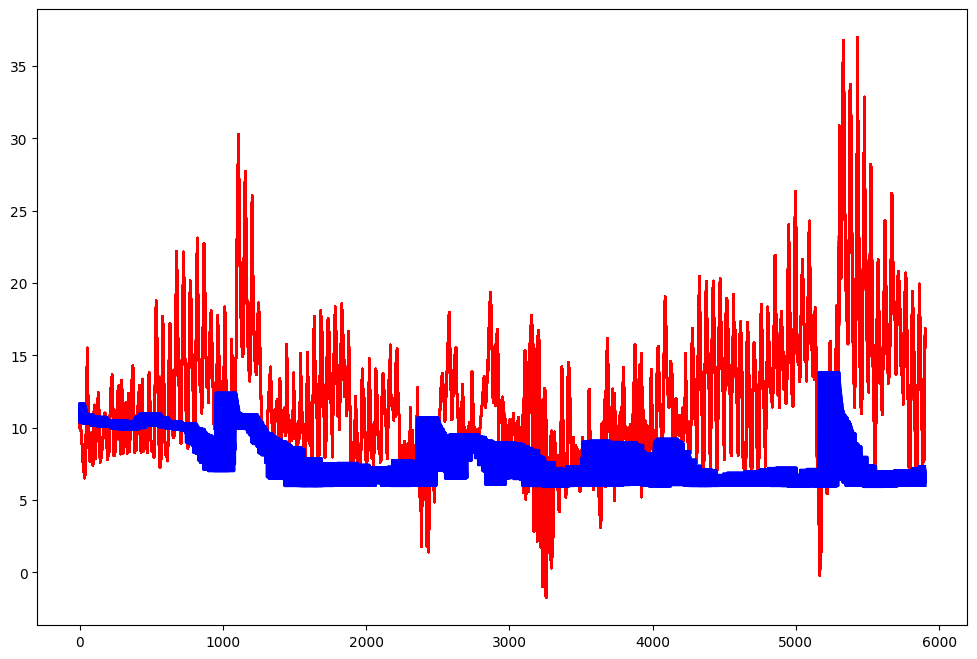

In [ ]:
import matplotlib.pyplot as plt

# Create a new figure object with a larger size
fig = plt.figure(figsize=(12, 8))

# Create your plot within the new figure object
plt.plot(test_predictions_denormalized , color = 'red')
plt.plot(test_output, color = 'blue')

# Display the plot
plt.show()

**gating network with only 2 parameters for each mixture component: loc (mean) and scale (standard deviation)**

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Multiply, Add
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_probability as tfp

def split_dataset(data):
  # split into standard weeks
  train, test = data[0:-6047], data[-1440:]
  #train, test = data[:-5817], data[-5817:-57] 6048
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test

def to_supervised(train, n_input):
    # Flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # Step over the entire history one time step at a time
    for _ in range(len(data)):
        # Define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + 1
        # Ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end, 0])  # Modify this line to only include the first future time step
        # Move along one time step
        in_start += 1
    return np.array(X), np.array(y)


train, test = split_dataset(df.values)


# Define the input and output dimensions
input_dim = df.shape[1]
output_dim = 1

# Define the number of experts
num_experts = 3

# Define the sizes of the hidden layers for each expert
expert_hidden_sizes = [16, 32, 64]

# Define the sizes of the output layers for each expert
expert_output_sizes = [144,144,144]

# Define the sizes of the gating network hidden layers
gating_hidden_sizes = [16, 8]

# Define the size of the output layer of the gating network
gating_output_size = num_experts

# Define the number of training iterations for the EM algorithm
num_iterations = 100

# Define the learning rate for the optimization algorithm
learning_rate = 0.0001

#Train test split
train, test = split_dataset(df.values)

# Input output
out, _ = to_supervised(train, 144)

# Load the training data
#train_data = np.array(df.head(17199))

# Reshape train_data so that the last column represents the output sequence
train_input = train.reshape(train.shape[0]*train.shape[1], train.shape[2])[:-145,:]
train_output = out[:,:,1]


def build_moe_model_with_autoencoder(input_dim, output_dim, expert_hidden_sizes, expert_output_sizes,
                                     gating_hidden_sizes, num_experts=3, learning_rate=0.0001,
                                     num_iterations=100):
    
    # Define the experts
    experts = []
    for i in range(num_experts):
        if i == 0:  # Replace first expert with an autoencoder
            expert_input = Input(shape=(input_dim,))
            expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_input)
            encoded = Dense(expert_output_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_hidden)
            expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(encoded)
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=encoded))  # Return encoded representation
        elif i == 1:  # Replace second expert with a CNN expert
            expert_input = Input(shape=(input_dim,))
            expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_input)
            expert_hidden = Dropout(0.2)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for CNN input
            expert_hidden = Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_normal')(expert_hidden)
            expert_hidden = MaxPooling1D(pool_size=2)(expert_hidden)
            expert_hidden = Flatten()(expert_hidden)
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))
        else:  # Replace third expert with an attention-based model
            expert_input = Input(shape=(input_dim,))
            expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_input)
            expert_hidden = Dropout(0.2)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for LSTM input
            expert_hidden, _ = LSTM(expert_hidden_sizes[i], return_state=True, kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))


    # Define the gating network
    gating_input = Input(shape=(input_dim,))
    gating_hidden = gating_input
    for i in range(len(gating_hidden_sizes)):
        gating_hidden = Dense(gating_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(gating_hidden)

    gating_output = Dense(num_experts + num_experts * 3, activation=None, kernel_initializer='he_normal')(gating_hidden)
    logits = gating_output[:, :num_experts]
    params = gating_output[:, num_experts:]
    params = tf.reshape(params, [-1, num_experts, 3])

    gating_distribution = tfp.distributions.MixtureSameFamily(
        mixture_distribution=tfp.distributions.Categorical(logits=logits),
        components_distribution=tfp.distributions.Normal(
            loc=params[..., 0],
            scale=tf.math.softplus(params[..., 1])
        ),
        weight_logits=params[..., 2]
    )

    gating_model = Model(inputs=gating_input, outputs=logits)

    # Define the MoE model
    inputs = Input(shape=(input_dim,))
    outputs = []
    for i in range(num_experts):
        expert_output = experts[i](inputs)
        if i == 0:  # For the autoencoder expert, append encoded representation to outputs list
            outputs.append(expert_output)
        else:
            outputs.append(experts[i](inputs))

    gating_output = gating_model(inputs)
    weighted_outputs = [gating_distribution.components_distribution[i].prob(expert_output) * gating_distribution.mixture_distribution.probs_parameter()[..., i, tf.newaxis] * expert_output for i, expert_output in enumerate(outputs)]


    outputs = tf.reduce_sum(weighted_outputs, axis=0)

    moe_model = Model(inputs=inputs, outputs=outputs)

    return moe_model, experts, gating_model


# Normalize input data
train_input = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)

# Pad output sequences to the same length

# train_output = pad_sequences(train_output, maxlen=max(expert_output_sizes), padding='post', dtype='float32')


moe_model, experts, gating_model = build_moe_model(input_dim, output_dim, expert_hidden_sizes,
                                                   expert_output_sizes, gating_hidden_sizes)

# Define the loss function
def moe_loss(y_true, y_pred, gating_output):
    y_true = tf.cast(y_true, y_pred.dtype)
    expert_losses = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    expert_losses = tf.expand_dims(expert_losses, axis=-1)
    
    # Apply softmax to the logits to get probabilities
    gating_probabilities = tf.nn.softmax(gating_output, axis=-1)
    
    # Multiply expert_losses with the gating probabilities instead of logits
    gating_losses = tf.reduce_sum(tf.multiply(expert_losses, gating_probabilities), axis=-1)
    return tf.reduce_mean(gating_losses)



# Define the optimization algorithm
optimizer = Adam(learning_rate=learning_rate)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


lr_scheduler = LearningRateScheduler(scheduler)

# Train the MoE model with the EM algorithm
# Train the MoE model with the EM algorithm
iteration = 0
while iteration < num_iterations:

    # E step: Compute the responsibilities of each expert for each data point
    gating_output = tf.constant(gating_model.predict(train_input), dtype=tf.float64)
    gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value

    # M step: Update the parameters of each expert and the gating network
    for i in range(num_experts):
        expert_input = train_input
        expert_output = experts[i](expert_input)
        expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        with tf.GradientTape() as tape:
            # Watch the trainable variables of the expert model
            tape.watch(experts[i].trainable_variables)

            # Define the expert model and calculate the expert_loss
            expert_output = experts[i](expert_input)
            expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        # Compute the gradients
        expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
        # Clip gradients for expert models
        expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

        # Update the variables
        optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))
    
    current_learning_rate = scheduler(iteration, optimizer.learning_rate.numpy())
    optimizer.learning_rate.assign(current_learning_rate)

    gating_input = train_input

    with tf.GradientTape() as tape:
        # Watch the trainable variables of the gating model
        tape.watch(gating_model.trainable_variables)

        # Define the gating model and calculate the gating_loss
        gating_output = gating_model(gating_input)
        gating_loss = moe_loss(tf.constant(train_output, dtype=tf.float32), moe_model(train_input), gating_output)


    # Compute the gradients
    gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
    # Clip gradients for the gating model
    gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]

    # Update the variables
    optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))

    # Evaluate the performance of the MoE model on the training set
    train_loss = moe_loss(train_output, moe_model.predict(train_input), gating_model.predict(train_input))


    print('Iteration %d: Training loss = %.6f' % (iteration + 1, train_loss))

    # Stop training if the learning rate becomes too small
    if current_learning_rate < 1e-6:
        print('Learning rate dropped below 1e-6 after iteration %d' % iteration)
        break

    iteration += 1

# Make predictions on the test set using the MoE model
# test_data = np.array(df[-144:])
# test_input = test_data[:, :]
# test_output = test_data[:, -1]
# test_output = [[int(x)] for x in test_output]

# Input output
out_test, _ = to_supervised(test, 144)

# Load the training data
#train_data = np.array(df.head(17199))

# Reshape train_data so that the last column represents the output sequence
test_input = test.reshape(test.shape[0]*test.shape[1], test.shape[2])[:-145,:]
test_output = out_test[:,:,1]

# Normalize test input data
test_input = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

# # Pad test output sequences to the same length
# test_output_padded = []
# for seq in test_output:
#     padded_seq = seq[:1] + [seq[0]] * (max_output_len - 1)
#     test_output_padded.append(padded_seq)
# test_output = np.array(test_output_padded)

# Make predictions on the test set using the MoE model
test_predictions = moe_model.predict(test_input)

test_loss = moe_loss(test_output, test_predictions, gating_model.predict(test_input))

print('Test loss = %.6f' % test_loss)
test_predictions_denormalized = test_predictions * np.std(train_output, axis=0) + np.mean(train_output, axis=0)

563/563 [==============================] - 1s 1ms/step
Iteration 1: Training loss = 155.509521
563/563 [==============================] - 1s 1ms/step
Iteration 2: Training loss = 154.122650
563/563 [==============================] - 1s 2ms/step
Iteration 3: Training loss = 152.605347
563/563 [==============================] - 1s 1ms/step
Iteration 4: Training loss = 150.953720
563/563 [==============================] - 1s 1ms/step
Iteration 5: Training loss = 149.174622
563/563 [==============================] - 1s 2ms/step
Iteration 6: Training loss = 147.280411
563/563 [==============================] - 1s 1ms/step
Iteration 7: Training loss = 145.287231
563/563 [==============================] - 1s 1ms/step
Iteration 8: Training loss = 143.213135
563/563 [==============================] - 1s 1ms/step
Iteration 9: Training loss = 141.050446
563/563 [==============================] - 1s 1ms/step
Iteration 10: Training loss = 138.836273
563/563 [==============================] - 1s 1ms

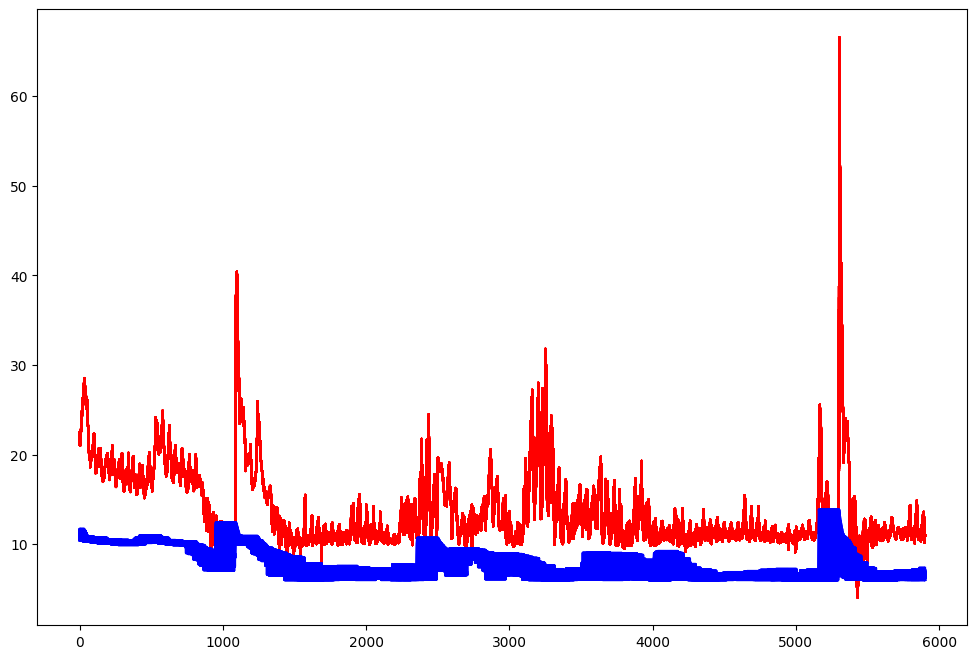

In [ ]:
import matplotlib.pyplot as plt

# Create a new figure object with a larger size
fig = plt.figure(figsize=(12, 8))

# Create your plot within the new figure object
plt.plot(test_predictions_denormalized , color = 'red')
plt.plot(test_output, color = 'blue')

# Display the plot
plt.show()

**Changing the optimization function from MSE to directly optimizing probability distribution using Negative Log Likelihood**

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Multiply, Add
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_probability as tfp

def split_dataset(data):
  # split into standard weeks
  train, test = data[0:-6047], data[-1440:]
  #train, test = data[:-5817], data[-5817:-57] 6048
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test

def to_supervised(train, n_input):
    # Flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # Step over the entire history one time step at a time
    for _ in range(len(data)):
        # Define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + 1
        # Ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end, 0])  # Modify this line to only include the first future time step
        # Move along one time step
        in_start += 1
    return np.array(X), np.array(y)


train, test = split_dataset(df.values)


# Define the input and output dimensions
input_dim = df.shape[1]
output_dim = 1

# Define the number of experts
num_experts = 3

# Define the sizes of the hidden layers for each expert
expert_hidden_sizes = [16, 32, 64]

# Define the sizes of the output layers for each expert
expert_output_sizes = [144,144,144]

# Define the sizes of the gating network hidden layers
gating_hidden_sizes = [16, 8]

# Define the size of the output layer of the gating network
gating_output_size = num_experts

# Define the number of training iterations for the EM algorithm
num_iterations = 100

# Define the learning rate for the optimization algorithm
learning_rate = 0.0001

#Train test split
train, test = split_dataset(df.values)

# Input output
out, _ = to_supervised(train, 144)

# Load the training data
#train_data = np.array(df.head(17199))

# Reshape train_data so that the last column represents the output sequence
train_input = train.reshape(train.shape[0]*train.shape[1], train.shape[2])[:-145,:]
train_output = out[:,:,1]


def build_moe_model_with_autoencoder(input_dim, output_dim, expert_hidden_sizes, expert_output_sizes,
                                     gating_hidden_sizes, num_experts=3, learning_rate=0.0001,
                                     num_iterations=100):
    
    # Define the experts
    experts = []
    for i in range(num_experts):
        if i == 0:  # Replace first expert with an autoencoder
            expert_input = Input(shape=(input_dim,))
            expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_input)
            encoded = Dense(expert_output_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_hidden)
            expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(encoded)
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=encoded))  # Return encoded representation
        elif i == 1:  # Replace second expert with a CNN expert
            expert_input = Input(shape=(input_dim,))
            expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_input)
            expert_hidden = Dropout(0.2)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for CNN input
            expert_hidden = Conv1D(filters=32, kernel_size=3, activation='relu', kernel_initializer='he_normal')(expert_hidden)
            expert_hidden = MaxPooling1D(pool_size=2)(expert_hidden)
            expert_hidden = Flatten()(expert_hidden)
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))
        else:  # Replace third expert with an attention-based model
            expert_input = Input(shape=(input_dim,))
            expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_input)
            expert_hidden = Dropout(0.2)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for LSTM input
            expert_hidden, _ = LSTM(expert_hidden_sizes[i], return_state=True, kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))


    # Define the gating network
    gating_input = Input(shape=(input_dim,))
    gating_hidden = gating_input
    for i in range(len(gating_hidden_sizes)):
        gating_hidden = Dense(gating_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(gating_hidden)

    gating_output = Dense(num_experts + num_experts * 3, activation=None, kernel_initializer='he_normal')(gating_hidden)
    logits = gating_output[:, :num_experts]
    params = gating_output[:, num_experts:]
    params = tf.reshape(params, [-1, num_experts, 3])

    gating_distribution = tfp.distributions.MixtureSameFamily(
        mixture_distribution=tfp.distributions.Categorical(logits=logits),
        components_distribution=tfp.distributions.Normal(
            loc=params[..., 0],
            scale=tf.math.softplus(params[..., 1])
        ),
        weight_logits=params[..., 2]
    )

    gating_model = Model(inputs=gating_input, outputs=logits)

    # Define the MoE model
    inputs = Input(shape=(input_dim,))
    outputs = []
    for i in range(num_experts):
        expert_output = experts[i](inputs)
        if i == 0:  # For the autoencoder expert, append encoded representation to outputs list
            outputs.append(expert_output)
        else:
            outputs.append(experts[i](inputs))

    gating_output = gating_model(inputs)
    weighted_outputs = [gating_distribution.components_distribution[i].prob(expert_output) * gating_distribution.mixture_distribution.probs_parameter()[..., i, tf.newaxis] * expert_output for i, expert_output in enumerate(outputs)]


    outputs = tf.reduce_sum(weighted_outputs, axis=0)

    moe_model = Model(inputs=inputs, outputs=outputs)

    return moe_model, experts, gating_model


# Normalize input data
train_input = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)

# Pad output sequences to the same length

# train_output = pad_sequences(train_output, maxlen=max(expert_output_sizes), padding='post', dtype='float32')


moe_model, experts, gating_model = build_moe_model(input_dim, output_dim, expert_hidden_sizes,
                                                   expert_output_sizes, gating_hidden_sizes)

# Define the loss function
def moe_loss(y_true, y_pred, gating_output):
    y_true = tf.cast(y_true, y_pred.dtype)
    expert_losses = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    expert_losses = tf.expand_dims(expert_losses, axis=-1)
    
    # Apply softmax to the logits to get probabilities
    gating_probabilities = tf.nn.softmax(gating_output, axis=-1)
    
    # Replace MSE with NLL
    nll = -tf.reduce_sum(tf.math.log(gating_probabilities + 1e-8) * expert_losses, axis=-1)
    return tf.reduce_mean(nll)




# Define the optimization algorithm
optimizer = Adam(learning_rate=learning_rate)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


lr_scheduler = LearningRateScheduler(scheduler)

# Train the MoE model with the EM algorithm
# Train the MoE model with the EM algorithm
iteration = 0
while iteration < num_iterations:

    # E step: Compute the responsibilities of each expert for each data point
    gating_output = tf.constant(gating_model.predict(train_input), dtype=tf.float64)
    gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value

    # M step: Update the parameters of each expert and the gating network
    for i in range(num_experts):
        expert_input = train_input
        expert_output = experts[i](expert_input)
        expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        with tf.GradientTape() as tape:
            # Watch the trainable variables of the expert model
            tape.watch(experts[i].trainable_variables)

            # Define the expert model and calculate the expert_loss
            expert_output = experts[i](expert_input)
            expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        # Compute the gradients
        expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
        # Clip gradients for expert models
        expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

        # Update the variables
        optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))
    
    current_learning_rate = scheduler(iteration, optimizer.learning_rate.numpy())
    optimizer.learning_rate.assign(current_learning_rate)

    gating_input = train_input

    with tf.GradientTape() as tape:
        # Watch the trainable variables of the gating model
        tape.watch(gating_model.trainable_variables)

        # Define the gating model and calculate the gating_loss
        gating_output = gating_model(gating_input)
        gating_loss = moe_loss(tf.constant(train_output, dtype=tf.float32), moe_model(train_input), gating_output)





    # Compute the gradients
    gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
    # Clip gradients for the gating model
    gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]

    # Update the variables
    optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))

    # Evaluate the performance of the MoE model on the training set
    train_loss = moe_loss(train_output, moe_model.predict(train_input), gating_model.predict(train_input))


    print('Iteration %d: Training loss = %.6f' % (iteration + 1, train_loss))

    # Stop training if the learning rate becomes too small
    if current_learning_rate < 1e-6:
        print('Learning rate dropped below 1e-6 after iteration %d' % iteration)
        break

    iteration += 1

# Make predictions on the test set using the MoE model
# test_data = np.array(df[-144:])
# test_input = test_data[:, :]
# test_output = test_data[:, -1]
# test_output = [[int(x)] for x in test_output]

# Input output
out_test, _ = to_supervised(test, 144)

# Load the training data
#train_data = np.array(df.head(17199))

# Reshape train_data so that the last column represents the output sequence
test_input = test.reshape(test.shape[0]*test.shape[1], test.shape[2])[:-145,:]
test_output = out_test[:,:,1]

# Normalize test input data
test_input = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

# # Pad test output sequences to the same length
# test_output_padded = []
# for seq in test_output:
#     padded_seq = seq[:1] + [seq[0]] * (max_output_len - 1)
#     test_output_padded.append(padded_seq)
# test_output = np.array(test_output_padded)

# Make predictions on the test set using the MoE model
test_predictions = moe_model.predict(test_input)

test_loss = moe_loss(test_output, test_predictions, gating_model.predict(test_input))

print('Test loss = %.6f' % test_loss)
test_predictions_denormalized = test_predictions * np.std(train_output, axis=0) + np.mean(train_output, axis=0)

563/563 [==============================] - 1s 1ms/step
Iteration 1: Training loss = 488.363586
563/563 [==============================] - 1s 2ms/step
Iteration 2: Training loss = 498.211914
563/563 [==============================] - 1s 1ms/step
Iteration 3: Training loss = 509.948212
563/563 [==============================] - 1s 1ms/step
Iteration 4: Training loss = 524.086975
563/563 [==============================] - 1s 1ms/step
Iteration 5: Training loss = 541.064819
563/563 [==============================] - 1s 1ms/step
Iteration 6: Training loss = 561.288574
563/563 [==============================] - 1s 1ms/step
Iteration 7: Training loss = 585.150146
563/563 [==============================] - 1s 1ms/step
Iteration 8: Training loss = 613.019836
563/563 [==============================] - 1s 1ms/step
Iteration 9: Training loss = 645.238403
563/563 [==============================] - 1s 1ms/step
Iteration 10: Training loss = 682.093323
563/563 [==============================] - 1s 1ms

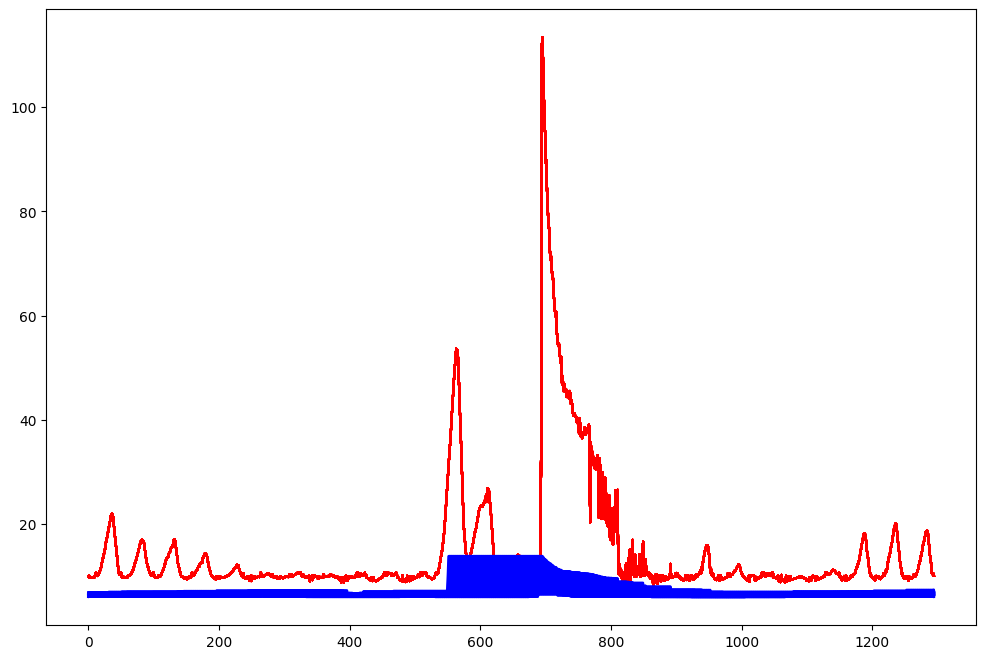

In [ ]:
import matplotlib.pyplot as plt

# Create a new figure object with a larger size
fig = plt.figure(figsize=(12, 8))

# Create your plot within the new figure object
plt.plot(test_predictions_denormalized , color = 'red')
plt.plot(test_output, color = 'blue')

# Display the plot
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_probability as tfp

def split_dataset(data):
  # split into standard weeks
  train, test = data[0:-6047], data[-432:]
  #train, test = data[:-5817], data[-5817:-57] 6048
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test

def to_supervised(train, n_input):
    # Flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # Step over the entire history one time step at a time
    for _ in range(len(data)):
        # Define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + 1
        # Ensure we have enough data for this instance
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end, 0])  # Modify this line to only include the first future time step
        # Move along one time step
        in_start += 1
    return np.array(X), np.array(y)


train, test = split_dataset(df.values)


# Define the input and output dimensions
input_dim = df.shape[1]
output_dim = 1

# Define the number of experts
num_experts = 3

# Define the sizes of the hidden layers for each expert
expert_hidden_sizes = [16, 32, 64]

# Define the sizes of the output layers for each expert
expert_output_sizes = [144,144,144]

# Define the sizes of the gating network hidden layers
gating_hidden_sizes = [16, 8]

# Define the size of the output layer of the gating network
gating_output_size = num_experts

# Define the number of training iterations for the EM algorithm
num_iterations = 100

# Define the learning rate for the optimization algorithm
learning_rate = 0.0001

#Train test split
train, test = split_dataset(df.values)

# Input output
out, _ = to_supervised(train, 144)

# Load the training data
#train_data = np.array(df.head(17199))

# Reshape train_data so that the last column represents the output sequence
train_input = train.reshape(train.shape[0]*train.shape[1], train.shape[2])[:-145,:]
train_output = out[:,:,1]


def build_moe_model_with_autoencoder(input_dim, output_dim, expert_hidden_sizes, expert_output_sizes,
                                     gating_hidden_sizes, num_experts=3, learning_rate=0.0001,
                                     num_iterations=100):
    
    # Define the experts
    experts = []
    for i in range(num_experts):
        if i == 0:  # Replace first expert with an autoencoder
            expert_input = Input(shape=(input_dim,))
            expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_input)
            encoded = Dense(expert_output_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_hidden)
            expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(encoded)
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=encoded))  # Return encoded representation
        else:
            expert_input = Input(shape=(input_dim,))
            expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_input)
            expert_hidden = Dropout(0.2)(expert_hidden)
            expert_output = Dense(expert_output_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_hidden)
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_output)
            experts.append(Model(inputs=expert_input, outputs=expert_output))

    # Define the gating network
    gating_input = Input(shape=(input_dim,))
    gating_hidden = gating_input
    for i in range(len(gating_hidden_sizes)):
        gating_hidden = Dense(gating_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(gating_hidden)

    gating_output = Dense(num_experts + num_experts * 2, activation=None, kernel_initializer='he_normal')(gating_hidden)
    logits = gating_output[:, :num_experts]
    params = gating_output[:, num_experts:]
    params = tf.reshape(params, [-1, num_experts, 2])

    gating_distribution = tfp.distributions.MixtureSameFamily(
        mixture_distribution=tfp.distributions.Categorical(logits=logits),
        components_distribution=tfp.distributions.Normal(
            loc=params[..., 0],
            scale=tf.math.softplus(params[..., 1])
        )
    )

    gating_model = Model(inputs=gating_input, outputs=logits)

    # Define the MoE model
    inputs = Input(shape=(input_dim,))
    outputs = []
    for i in range(num_experts):
        expert_output = experts[i](inputs)
        if i == 0:  # For the autoencoder expert, append encoded representation to outputs list
            outputs.append(expert_output)
        else:
            outputs.append(experts[i](inputs))

    gating_output = gating_model(inputs)
    weighted_outputs = [tf.expand_dims(gating_output[:, i], axis=-1) * expert_output for i, expert_output in enumerate(outputs)]

    outputs = tf.reduce_sum(weighted_outputs, axis=0)

    moe_model = Model(inputs=inputs, outputs=outputs)

    return moe_model, experts, gating_model


# Normalize input data
train_input = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)

# Pad output sequences to the same length

# train_output = pad_sequences(train_output, maxlen=max(expert_output_sizes), padding='post', dtype='float32')


moe_model, experts, gating_model = build_moe_model(input_dim, output_dim, expert_hidden_sizes,
                                                   expert_output_sizes, gating_hidden_sizes)

# Define the loss function
def moe_loss(y_true, y_pred, gating_output):
    y_true = tf.cast(y_true, y_pred.dtype)
    expert_losses = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    expert_losses = tf.expand_dims(expert_losses, axis=-1)
    
    # Apply softmax to the logits to get probabilities
    gating_probabilities = tf.nn.softmax(gating_output, axis=-1)
    
    # Multiply expert_losses with the gating probabilities instead of logits
    gating_losses = tf.reduce_sum(tf.multiply(expert_losses, gating_probabilities), axis=-1)
    return tf.reduce_mean(gating_losses)



# Define the optimization algorithm
optimizer = Adam(learning_rate=learning_rate)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


lr_scheduler = LearningRateScheduler(scheduler)

# Train the MoE model with the EM algorithm
# Train the MoE model with the EM algorithm
iteration = 0
while iteration < num_iterations:

    # E step: Compute the responsibilities of each expert for each data point
    gating_output = tf.constant(gating_model.predict(train_input), dtype=tf.float64)
    gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value

    # M step: Update the parameters of each expert and the gating network
    for i in range(num_experts):
        expert_input = train_input
        expert_output = experts[i](expert_input)
        expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        with tf.GradientTape() as tape:
            # Watch the trainable variables of the expert model
            tape.watch(experts[i].trainable_variables)

            # Define the expert model and calculate the expert_loss
            expert_output = experts[i](expert_input)
            expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        # Compute the gradients
        expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
        # Clip gradients for expert models
        expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

        # Update the variables
        optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))
    
    current_learning_rate = scheduler(iteration, optimizer.learning_rate.numpy())
    optimizer.learning_rate.assign(current_learning_rate)

    gating_input = train_input

    with tf.GradientTape() as tape:
        # Watch the trainable variables of the gating model
        tape.watch(gating_model.trainable_variables)

        # Define the gating model and calculate the gating_loss
        gating_output = gating_model(gating_input)
        gating_loss = moe_loss(tf.constant(train_output, dtype=tf.float32), moe_model(train_input), gating_output)





    # Compute the gradients
    gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
    # Clip gradients for the gating model
    gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]

    # Update the variables
    optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))

    # Evaluate the performance of the MoE model on the training set
    train_loss = moe_loss(train_output, moe_model.predict(train_input), gating_model.predict(train_input))


    print('Iteration %d: Training loss = %.6f' % (iteration + 1, train_loss))

    # Stop training if the learning rate becomes too small
    if current_learning_rate < 1e-6:
        print('Learning rate dropped below 1e-6 after iteration %d' % iteration)
        break

    iteration += 1

# Make predictions on the test set using the MoE model
# test_data = np.array(df[-144:])
# test_input = test_data[:, :]
# test_output = test_data[:, -1]
# test_output = [[int(x)] for x in test_output]

# Input output
out_test, _ = to_supervised(test, 144)

# Load the training data
#train_data = np.array(df.head(17199))

# Reshape train_data so that the last column represents the output sequence
test_input = test.reshape(test.shape[0]*test.shape[1], test.shape[2])[:-145,:]
test_output = out_test[:,:,1]

# Normalize test input data
test_input = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

# # Pad test output sequences to the same length
# test_output_padded = []
# for seq in test_output:
#     padded_seq = seq[:1] + [seq[0]] * (max_output_len - 1)
#     test_output_padded.append(padded_seq)
# test_output = np.array(test_output_padded)

# Make predictions on the test set using the MoE model
test_predictions = moe_model.predict(test_input)

test_loss = moe_loss(test_output, test_predictions, gating_model.predict(test_input))

print('Test loss = %.6f' % test_loss)

563/563 [==============================] - 1s 1ms/step
Iteration 1: Training loss = 214.329041
563/563 [==============================] - 1s 2ms/step
Iteration 2: Training loss = 212.905899
563/563 [==============================] - 1s 2ms/step
Iteration 3: Training loss = 211.360413
563/563 [==============================] - 1s 1ms/step
Iteration 4: Training loss = 209.667877
563/563 [==============================] - 1s 2ms/step
Iteration 5: Training loss = 207.825867
563/563 [==============================] - 1s 1ms/step
Iteration 6: Training loss = 205.839417
563/563 [==============================] - 1s 1ms/step
Iteration 7: Training loss = 203.717682
563/563 [==============================] - 1s 1ms/step
Iteration 8: Training loss = 201.471634
563/563 [==============================] - 1s 1ms/step
Iteration 9: Training loss = 199.114120
563/563 [==============================] - 1s 1ms/step
Iteration 10: Training loss = 196.658615
563/563 [==============================] - 1s 1ms

In [ ]:
pip install optuna

In [ ]:
import optuna

In [ ]:
def objective(trial):
    # Define the input and output dimensions
    input_dim = 1
    output_dim = 1

    # Suggest hyperparameters using Optuna
    num_experts = trial.suggest_int("num_experts", 2, 5)
    expert_hidden_sizes = [
        trial.suggest_int(f"expert_hidden_size_{i}", 16, 64) for i in range(num_experts)
    ]
    expert_output_sizes = [
        trial.suggest_int(f"expert_output_size_{i}", 16, 64) for i in range(num_experts)
    ]
    gating_hidden_sizes = [
        trial.suggest_int(f"gating_hidden_size_{i}", 8, 32) for i in range(2)
    ]
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)

    # Load the training data
    train_data = np.array(df.head(1000))

    # Split the training data into input and output sequences
    train_input = train_data[:, :-1]
    print('train_input shape', train_input.shape)
    train_output = train_data[:, -1:]
    print('train_output shape', train_output.shape)

    # Define the experts
    experts = []
    for i in range(num_experts):
        expert_input = Input(shape=(input_dim,))
        expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_input)
        expert_hidden = Dropout(0.2)(expert_hidden)
        expert_output = Dense(expert_output_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_hidden)
        expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_output)  # Add this line
        experts.append(Model(inputs=expert_input, outputs=expert_output))

    # Define the gating network
    gating_input = Input(shape=(input_dim,))
    gating_hidden = gating_input
    for i in range(len(gating_hidden_sizes)):
        gating_hidden = Dense(gating_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(gating_hidden)

    gating_output = Dense(num_experts + num_experts * 2, activation=None, kernel_initializer='he_normal')(gating_hidden)
    logits = gating_output[:, :num_experts]
    params = gating_output[:, num_experts:]
    params = tf.reshape(params, [-1, num_experts, 2])

    gating_distribution = tfp.distributions.MixtureSameFamily(
        mixture_distribution=tfp.distributions.Categorical(logits=logits),
        components_distribution=tfp.distributions.Normal(
            loc=params[..., 0],
            scale=tf.math.softplus(params[..., 1])
        )
    )

    gating_model = Model(inputs=gating_input, outputs=logits)

    # Define the MoE model
    inputs = Input(shape=(input_dim,))
    outputs = []
    for i in range(num_experts):
        expert_output = experts[i](inputs)
        outputs.append(expert_output)

    gating_output = gating_model(inputs)
    weighted_outputs = [tf.expand_dims(gating_output[:, i], axis=-1) * expert_output for i, expert_output in enumerate(outputs)]

    outputs = tf.reduce_sum(weighted_outputs, axis=0)

    moe_model = Model(inputs=inputs, outputs=outputs)

    # Define the loss function
    def moe_loss(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        expert_losses = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
        expert_losses = tf.expand_dims(expert_losses, axis=-1)
        
        # Calculate the gating output using the provided inputs
        gating_output = gating_model(y_pred)
        
        # Apply softmax to the logits to get probabilities
        gating_probabilities = tf.nn.softmax(gating_output, axis=-1)
        
        print("y_true.shape: ", y_true.shape)
        print("y_pred.shape: ", y_pred.shape)
        print("expert_losses.shape: ", expert_losses.shape)
        print("gating_probabilities.shape: ", gating_probabilities.shape)
        
        # Multiply expert_losses with the gating probabilities instead of logits
        gating_losses = tf.reduce_sum(tf.multiply(expert_losses, gating_probabilities), axis=-1)
        return tf.reduce_mean(gating_losses)


    # Define the optimization algorithm
    optimizer = Adam(lr=learning_rate)

    # Train the MoE model with the EM algorithm
    for iteration in range(num_iterations):
        # E step: Compute the responsibilities of each expert for each data point
        gating_output = tf.constant(gating_model.predict(train_input), dtype=tf.float64)
        gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value


        # M step: Update the parameters of each expert and the gating network
        for i in range(num_experts):
            expert_input = train_input
            expert_output = experts[i](expert_input)
            expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)
            
            with tf.GradientTape() as tape:
                # Watch the trainable variables of the expert model
                tape.watch(experts[i].trainable_variables)

                # Define the expert model and calculate the expert_loss
                expert_output = experts[i](expert_input)
                expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

            # Compute the gradients
            expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
            # Clip gradients for expert models
            expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

            # Update the variables
            for var, grad in zip(experts[i].trainable_variables, expert_gradient):
                var.assign_sub(learning_rate * grad)

        gating_input = train_input
        
        with tf.GradientTape() as tape:
          # Watch the trainable variables of the gating model
          tape.watch(gating_model.trainable_variables)

          # Define the gating model and calculate the gating_loss
          gating_output = gating_model(gating_input)
          gating_loss = moe_loss(tf.constant(train_output, dtype=tf.float32), moe_model(gating_input))

        # Compute the gradients
        gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
        # Clip gradients for the gating model
        gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]
        
        # Update the variables
        for var, grad in zip(gating_model.trainable_variables, gating_gradient):
          var.assign_sub(learning_rate * grad)

        # Evaluate the performance of the MoE model on the training set
        train_loss = moe_loss(train_output, moe_model.predict(train_input))
        print('Iteration %d: Training loss = %.6f' % (iteration + 1, train_loss))

    # Make predictions on the test set using the MoE model
    test_data = np.array(df[-1000:])
    test_input = test_data[:, :-1]
    test_output = test_data[:, -1:]
    test_predictions = moe_model.predict(test_input)

    test_loss = moe_loss(test_output, test_predictions)
    print('Test loss = %.6f' % test_loss)

    return test_loss  # Return the test loss to be minimized

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  # Set the number of trials you want to run

# Print the best hyperparameters found
print("Best trial:")
trial = study.best_trial
print(f"Value: {trial.value}")
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [ ]:
import numpy as np
from tensorflow import keras
from keras import layers
from sklearn.mixture import GaussianMixture

# Generate example time series data
df = dataset[['S2_Top_VWC_Avg']]
data = np.array(df)

# Define segment length
segment_length = 50

# Segment the time series data
segments = np.array([data[i:i+segment_length] for i in range(0, len(data)-segment_length)])

# Define the deep learning models
models = []
models.append(keras.Sequential([
    layers.Input(shape=(segment_length, 1)),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(units=128, activation='relu'),
    layers.Dense(units=1, activation='linear')
]))
models.append(keras.Sequential([
    layers.Input(shape=(segment_length, 1)),
    layers.LSTM(units=64, return_sequences=True),
    layers.LSTM(units=32),
    layers.Dense(units=1, activation='linear')
]))

# Compile the models
for model in models:
    model.compile(loss='mse', optimizer='adam')

# Fit each model to each segment
for model in models:
    for i, segment in enumerate(segments):
        X = segment[:-1].reshape(-1, segment_length-1, 1)
        y = segment[1:].reshape(-1, 1)
        model.fit(X, y, epochs=10, batch_size=32, verbose=0)

# Fit a Gaussian mixture model to learn segment weights
gmm = GaussianMixture(n_components=len(segments), covariance_type='full')
gmm.fit(segments)

# Use the segment weights to combine the predictions of the models
def predict(x):
    segment_index = gmm.predict(x.reshape(1, -1))[0]
    segment = segments[segment_index]
    model = models[segment_index % len(models)]
    X = segment[:-1].reshape(-1, segment_length-1, 1)
    y = segment[1:].reshape(-1, 1)
    model.fit(X, y, epochs=10, batch_size=32, verbose=0)
    return model.predict(x.reshape(1, -1, 1))[0][0]

# Make a forecast using the mixture of experts model
forecast = [predict(data[i:i+segment_length]) for i in range(len(data)-segment_length)]


**3 models plus LSTM**

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM
from keras.optimizers import Adam
import tensorflow_probability as tfp
from xgboost import XGBRegressor

tf.config.experimental_run_functions_eagerly(True)

# Define the input and output dimensions
input_dim = df.shape[1]
output_dim = 1

# Define the number of experts
num_experts = 5

# Define the sizes of the hidden layers for each expert
expert_hidden_sizes = [16, 32, 64, 128]

# Define the sizes of the output layers for each expert
expert_output_sizes = [32, 32, 32, 128]

# Define the sizes of the gating network hidden layers
gating_hidden_sizes = [16, 8]

# Define the size of the output layer of the gating network
gating_output_size = num_experts

# Define the number of training iterations for the EM algorithm
num_iterations = 100

# Define the learning rate for the optimization algorithm
learning_rate = 0.0001

# Load the training data
train_data = np.array(df.head(1000))

# Split the training data into input and output sequences
train_input = train_data[:, :]
print('train_input shape', train_input.shape)
train_output = train_data[:, -1:]
print('train_output shape', train_output.shape)

# Reshape the training input for the LSTM expert
train_input_lstm = np.reshape(train_input, (train_input.shape[0], train_input.shape[1], 1))

# Define the experts
experts = []
for i in range(4):
    expert_input = Input(shape=(input_dim,))
    expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_input)
    expert_hidden = Dropout(0.2)(expert_hidden)
    expert_output = Dense(expert_output_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_hidden)
    expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_output)  # Add this line
    experts.append(Model(inputs=expert_input, outputs=expert_output))

# Define the LSTM expert
lstm_expert_input = Input(shape=(input_dim, 1))
lstm_expert_hidden = LSTM(64, activation='relu', return_sequences=True)(lstm_expert_input)
lstm_expert_hidden = LSTM(32, activation='relu', return_sequences=False)(lstm_expert_hidden)
lstm_expert_output = Dense(output_dim, activation='linear')(lstm_expert_hidden)
lstm_expert = Model(inputs=lstm_expert_input, outputs=lstm_expert_output)

# Add the LSTM expert to the list of experts
experts.append(lstm_expert)

# Define the gating network
gating_input = Input(shape=(input_dim,))
gating_hidden = gating_input
for i in range(len(gating_hidden_sizes)):
    gating_hidden = Dense(gating_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(gating_hidden)

gating_output = Dense(num_experts + num_experts * 2, activation=None, kernel_initializer='he_normal')(gating_hidden)
logits = gating_output[:, :num_experts]
params = gating_output[:, num_experts:]
params = tf.reshape(params, [-1, num_experts, 2])

gating_distribution = tfp.distributions.MixtureSameFamily(
    mixture_distribution=tfp.distributions.Categorical(logits=logits),
    components_distribution=tfp.distributions.Normal(
        loc=params[..., 0],
        scale=tf.math.softplus(params[..., 1])
    )
)

gating_model = Model(inputs=gating_input, outputs=logits)

# Define the MoE model
inputs = Input(shape=(input_dim,))
outputs = []
for i in range(4):
    expert_output = experts[i](inputs)
    outputs.append(expert_output)

# Add LSTM expert output to the list of outputs
lstm_outputs = experts[4](tf.expand_dims(inputs, axis=-1))
outputs.append(lstm_outputs)

gating_output = gating_model(inputs)
weighted_outputs = [tf.expand_dims(gating_output[:, i], axis=-1) * expert_output for i, expert_output in enumerate(outputs)]

outputs = tf.reduce_sum(weighted_outputs, axis=0)

moe_model = Model(inputs=inputs, outputs=outputs)

# Define the loss function
def moe_loss(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    expert_losses = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    expert_losses = tf.expand_dims(expert_losses, axis=-1)
    
    # Apply softmax to the logits to get probabilities
    gating_probabilities = tf.nn.softmax(gating_output, axis=-1)
    
    # Multiply expert_losses with the gating probabilities instead of logits
    gating_losses = tf.reduce_sum(tf.multiply(expert_losses, gating_probabilities), axis=-1)
    return tf.reduce_mean(gating_losses)


# Define the optimization algorithm
optimizer = Adam(lr=learning_rate)

# Train the MoE model with the EM algorithm
for iteration in range(num_iterations):
    # E step: Compute the responsibilities of each expert for each data point
    gating_output = tf.constant(gating_model.predict(train_input), dtype=tf.float64)
    gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value


    # M step: Update the parameters of each expert and the gating network
    for i in range(num_experts):
        expert_input = train_input
        expert_output = experts[i](expert_input)
        expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)
        
        with tf.GradientTape() as tape:
            # Watch the trainable variables of the expert model
            tape.watch(experts[i].trainable_variables)

            # Define the expert model and calculate the expert_loss
            expert_output = experts[i](expert_input)
            expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        # Compute the gradients
        expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
        # Clip gradients for expert models
        expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

        # Update the variables
        optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))


    gating_input = train_input
    
    with tf.GradientTape() as tape:
      # Watch the trainable variables of the gating model
      tape.watch(gating_model.trainable_variables)

      # Define the gating model and calculate the gating_loss
      gating_output = gating_model(gating_input)
      gating_loss = moe_loss(tf.constant(train_output, dtype=tf.float32), moe_model(gating_input))

    # Compute the gradients
    gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
    # Clip gradients for the gating model
    gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]
    
    # Update the variables
    optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))


    # Evaluate the performance of the MoE model on the training set
    train_loss = moe_loss(train_output, moe_model.predict(train_input))
    print('Iteration %d: Training loss = %.6f' % (iteration + 1, train_loss))

# Make predictions on the test set using the MoE model
test_data = np.array(df[-1000:])
test_input = test_data[:, :]
test_output = test_data[:, -1:]
test_predictions = moe_model.predict(test_input)

test_loss = moe_loss(test_output, test_predictions)
print('Test loss = %.6f' % test_loss)



train_input shape (1000, 2)
train_output shape (1000, 1)


32/32 [==============================] - 0s 4ms/step


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


32/32 [==============================] - 1s 43ms/step
Iteration 1: Training loss = 1024112.062500
32/32 [==============================] - 1s 41ms/step
Iteration 2: Training loss = 980264.187500
32/32 [==============================] - 2s 62ms/step
Iteration 3: Training loss = 930691.437500
32/32 [==============================] - 3s 96ms/step
Iteration 4: Training loss = 875062.937500
32/32 [==============================] - 1s 39ms/step
Iteration 5: Training loss = 813989.375000
32/32 [==============================] - 1s 41ms/step
Iteration 6: Training loss = 748527.312500
32/32 [==============================] - 2s 57ms/step
Iteration 7: Training loss = 679969.250000
32/32 [==============================] - 1s 42ms/step
Iteration 8: Training loss = 609678.375000
32/32 [==============================] - 1s 42ms/step
Iteration 9: Training loss = 539045.750000
32/32 [==============================] - 1s 42ms/step
Iteration 10: Training loss = 469404.281250
32/32 [=====================

In [ ]:
def create_lstm_encoder_decoder(n_input, n_timesteps, n_features, n_outputs, n_nodes):
    inputs = Input(shape=(n_timesteps, n_features))

    # encoder layers
    encoder = tf.keras.layers.LSTM(n_nodes)(inputs)
    encoder = tf.keras.layers.RepeatVector(n_outputs)(encoder)

    # decoder layers
    decoder = tf.keras.layers.LSTM(n_nodes, return_sequences=True)(encoder)
    decoder = tf.keras.layers.TimeDistributed(Dense(n_nodes // 2))(decoder)
    decoder = tf.keras.layers.TimeDistributed(Dense(1))(decoder)

    model = Model(inputs=inputs, outputs=decoder)
    model.compile(loss='mae', optimizer='adam')

    return model

In [ ]:
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
import tensorflow_probability as tfp

tf.config.experimental_run_functions_eagerly(True)

# Define the input and output dimensions
input_dim = df.shape[1]
output_dim = 1

# Define the number of experts
num_experts = 3

# Define the sizes of the hidden layers for each expert
expert_hidden_sizes = [16, 32, 64]

# Define the sizes of the output layers for each expert
expert_output_sizes = [32, 32, 32]

# Define the sizes of the gating network hidden layers
gating_hidden_sizes = [16, 8]

# Define the size of the output layer of the gating network
gating_output_size = num_experts

# Define the number of training iterations for the EM algorithm
num_iterations = 100

# Define the learning rate for the optimization algorithm
learning_rate = 0.0001

# Load the training data
train_data = np.array(df.head(1000))

# Split the training data into input and output sequences
train_input = train_data[:, :]
print('train_input shape', train_input.shape)
train_output = train_data[:, -1:]
print('train_output shape', train_output.shape)

# Define the experts
experts = []
for i in range(num_experts):
    if i != 1:  # Replace the second expert with the LSTM encoder-decoder
        expert_input = Input(shape=(input_dim,))
        expert_hidden = Dense(expert_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_input)
        expert_hidden = Dropout(0.2)(expert_hidden)
        expert_output = Dense(expert_output_sizes[i], activation='relu', kernel_initializer='he_normal')(expert_hidden)
        expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_output)
        experts.append(Model(inputs=expert_input, outputs=expert_output))
    else:
        n_input = input_dim  # Modify this value according to the input dimension of your LSTM encoder-decoder
        n_timesteps = 1  # Modify this value according to the number of timesteps of your LSTM encoder-decoder
        n_features = input_dim  # Modify this value according to the number of features of your LSTM encoder-decoder
        n_outputs = 1  # Modify this value according to the number of outputs of your LSTM encoder-decoder
        n_nodes = 32  # Modify this value according to the number of nodes of your LSTM encoder-decoder
        lstm_expert = create_lstm_encoder_decoder(n_input, n_timesteps, n_features, n_outputs, n_nodes)
        experts.append(lstm_expert)

# Define the gating network
gating_input = Input(shape=(input_dim,))
gating_hidden = gating_input
for i in range(len(gating_hidden_sizes)):
    gating_hidden = Dense(gating_hidden_sizes[i], activation='relu', kernel_initializer='he_normal')(gating_hidden)

gating_output = Dense(num_experts + num_experts * 2, activation=None, kernel_initializer='he_normal')(gating_hidden)
logits = gating_output[:, :num_experts]
params = gating_output[:, num_experts:]
params = tf.reshape(params, [-1, num_experts, 2])

gating_distribution = tfp.distributions.MixtureSameFamily(
    mixture_distribution=tfp.distributions.Categorical(logits=logits),
    components_distribution=tfp.distributions.Normal(
        loc=params[..., 0],
        scale=tf.math.softplus(params[..., 1])
    )
)

gating_model = Model(inputs=gating_input, outputs=logits)

# Define the MoE model
inputs = Input(shape=(input_dim,))
outputs = []
for i in range(num_experts):
    expert_output = experts[i](inputs)
    outputs.append(expert_output)

gating_output = gating_model(inputs)
weighted_outputs = [tf.expand_dims(gating_output[:, i], axis=-1) * expert_output for i, expert_output in enumerate(outputs)]

outputs = tf.reduce_sum(weighted_outputs, axis=0)

moe_model = Model(inputs=inputs, outputs=outputs)

# Define the loss function
def moe_loss(y_true, y_pred):
    y_true = tf.cast(y_true, y_pred.dtype)
    expert_losses = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    expert_losses = tf.expand_dims(expert_losses, axis=-1)
    
    # Apply softmax to the logits to get probabilities
    gating_probabilities = tf.nn.softmax(gating_output, axis=-1)
    
    # Multiply expert_losses with the gating probabilities instead of logits
    gating_losses = tf.reduce_sum(tf.multiply(expert_losses, gating_probabilities), axis=-1)
    return tf.reduce_mean(gating_losses)



# Define the optimization algorithm
optimizer = Adam(lr=learning_rate)

# Train the MoE model with the EM algorithm
for iteration in range(num_iterations):
    # E step: Compute the responsibilities of each expert for each data point
    gating_output = tf.constant(gating_model.predict(train_input), dtype=tf.float64)
    gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value


    # M step: Update the parameters of each expert and the gating network
    for i in range(num_experts):
        expert_input = train_input
        expert_output = experts[i](expert_input)
        expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)
        
        with tf.GradientTape() as tape:
            # Watch the trainable variables of the expert model
            tape.watch(experts[i].trainable_variables)

            # Define the expert model and calculate the expert_loss
            expert_output = experts[i](expert_input)
            expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        # Compute the gradients
        expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
        # Clip gradients for expert models
        expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

        # Update the variables
        optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))


    gating_input = train_input
    
    with tf.GradientTape() as tape:
      # Watch the trainable variables of the gating model
      tape.watch(gating_model.trainable_variables)

      # Define the gating model and calculate the gating_loss
      gating_output = gating_model(gating_input)
      gating_loss = moe_loss(tf.constant(train_output, dtype=tf.float32), moe_model(gating_input))

    # Compute the gradients
    gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
    # Clip gradients for the gating model
    gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]
    
    # Update the variables
    optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))


    # Evaluate the performance of the MoE model on the training set
    train_loss = moe_loss(train_output, moe_model.predict(train_input))
    print('Iteration %d: Training loss = %.6f' % (iteration + 1, train_loss))

# Make predictions on the test set using the MoE model
test_data = np.array(df[-1000:])
test_input = test_data[:, :]
test_output = test_data[:, -1:]
test_predictions = moe_model.predict(test_input)

test_loss = moe_loss(test_output, test_predictions)
print('Test loss = %.6f' % test_loss)


train_input shape (1000, 2)
train_output shape (1000, 1)


ValueError: ignored